In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import kagglehub
from sklearn.model_selection import train_test_split

### This dataset for tiny-imagenet

In [2]:
# Veri setini indir
path = kagglehub.dataset_download("akash2sharma/tiny-imagenet")
print("Path to dataset files:", path)
path = path + "/tiny-imagenet-200"

Path to dataset files: /kaggle/input/tiny-imagenet


### This is for stl-10 dataset

In [ ]:
# Bunu böyle kagglehub ile indirince bütün dataset iniyormuş, böyle yapmaktansa Input sekmesinden Add Input tıkla oradan dataseti seç
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("jessicali9530/stl10")

# print("Path to dataset files:", path)  

In [2]:
path = "/kaggle/input/stl10/"
train_path = path + "train_images"
test_path = path + "test_images"

In [18]:
class HyperUNet(nn.Module):
    """
    Hyper-U-Net mimarisi - U-Net'e hypercolumn bağlantıları eklenir
    """
    def __init__(self, input_channels=1, output_channels=2):
        super(HyperUNet, self).__init__()
        
        # Encoder (Downsampling)
        self.enc1 = self.conv_block(input_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        
        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)
        
        # Decoder (Upsampling)
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = self.conv_block(1024, 512)  # 512 + 512 from skip connection
        
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = self.conv_block(512, 256)   # 256 + 256 from skip connection
        
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = self.conv_block(256, 128)   # 128 + 128 from skip connection
        
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = self.conv_block(128, 64)    # 64 + 64 from skip connection
        
        # Hyper-column connections
        # Bu bağlantılar farklı seviyelerden özellikleri birleştirir
        self.hyper_conv1 = nn.Conv2d(64, 32, 1)
        self.hyper_conv2 = nn.Conv2d(128, 32, 1)
        self.hyper_conv3 = nn.Conv2d(256, 32, 1)
        self.hyper_conv4 = nn.Conv2d(512, 32, 1)
        
        # Final layer - hypercolumn features + final decoder features
        self.final_conv = nn.Conv2d(64 + 32*4, output_channels, 1)  # 64 + 128 = 192
        
        self.pool = nn.MaxPool2d(2, 2)
        
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e1_pool = self.pool(e1)
        
        e2 = self.enc2(e1_pool)
        e2_pool = self.pool(e2)
        
        e3 = self.enc3(e2_pool)
        e3_pool = self.pool(e3)
        
        e4 = self.enc4(e3_pool)
        e4_pool = self.pool(e4)
        
        # Bottleneck
        bottleneck = self.bottleneck(e4_pool)
        
        # Decoder
        d4 = self.up4(bottleneck)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)
        
        d3 = self.up3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        
        # Hyper-column features - farklı seviyelerden özellikleri birleştir
        h1 = self.hyper_conv1(e1)  # 64x64
        h2 = F.interpolate(self.hyper_conv2(e2), size=(64, 64), mode='bilinear', align_corners=False)
        h3 = F.interpolate(self.hyper_conv3(e3), size=(64, 64), mode='bilinear', align_corners=False)
        h4 = F.interpolate(self.hyper_conv4(e4), size=(64, 64), mode='bilinear', align_corners=False)
        
        # Tüm hyper-column features'ları birleştir
        hyper_features = torch.cat([h1, h2, h3, h4], dim=1)
        
        # Final features: decoder output + hyper-column features
        final_features = torch.cat([d1, hyper_features], dim=1)
        
        # Final output
        output = self.final_conv(final_features)
        return torch.tanh(output)  # a,b channels için -1 ile 1 arası

class ColorizationDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Resmi RGB olarak yükle
        image_path = self.image_paths[idx]
        rgb_image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            rgb_image = self.transform(rgb_image)
        
        # RGB'yi tensor'e çevir
        rgb_tensor = transforms.ToTensor()(rgb_image)
        
        # LAB renk uzayına çevir
        rgb_np = rgb_tensor.permute(1, 2, 0).numpy()
        rgb_np = (rgb_np * 255).astype(np.uint8)
        
        lab_image = cv2.cvtColor(rgb_np, cv2.COLOR_RGB2LAB)
        lab_image = lab_image.astype(np.float32) / 255.0
        
        # L kanalını input olarak kullan (grayscale)
        L = lab_image[:, :, 0:1]  # Shape: (64, 64, 1)
        L = torch.from_numpy(L).permute(2, 0, 1)  # (1, 64, 64)
        
        # a,b kanallarını target olarak kullan
        ab = lab_image[:, :, 1:3]  # Shape: (64, 64, 2)
        ab = torch.from_numpy(ab).permute(2, 0, 1)  # (2, 64, 64)
        ab = ab * 2.0 - 1.0  # [-1, 1] aralığına normalize et
        
        return L, ab

def get_image_paths(data_path):
    """Tiny ImageNet veri setinden tüm resim yollarını al"""
    image_paths = []
    
    # Train klasöründeki resimleri al
    train_path = os.path.join(data_path, 'train')
    if os.path.exists(train_path):
        for class_folder in os.listdir(train_path):
            class_path = os.path.join(train_path, class_folder, 'images')
            if os.path.exists(class_path):
                for img_name in os.listdir(class_path):
                    if img_name.endswith(('.JPEG', '.jpg', '.png')):
                        image_paths.append(os.path.join(class_path, img_name))
    
    return image_paths

def lab_to_rgb(L, ab):
    """LAB tensor'ları RGB'ye çevir"""
    L = L.squeeze(0).cpu().numpy()  # (64, 64)
    ab = ab.cpu().numpy()  # (2, 64, 64)
    
    # [-1, 1]'den [0, 1]'e
    ab = (ab + 1.0) / 2.0
    
    # LAB formatına çevir
    lab = np.zeros((64, 64, 3))
    lab[:, :, 0] = L
    lab[:, :, 1] = ab[0]
    lab[:, :, 2] = ab[1]
    
    # [0, 1]'den [0, 255]'e
    lab = (lab * 255).astype(np.uint8)
    
    # RGB'ye çevir
    rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    return rgb

def train_model():
    # Device seçimi
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Veri yollarını al
    image_paths = get_image_paths(path)
    print(f"Total images found: {len(image_paths)}")
    
    # Train/validation split
    train_paths, val_paths = train_test_split(image_paths, test_size=0.2, random_state=42)
    
    # Transform
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(p=0.5),
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((64, 64)),
    ])
    
    # Dataset ve DataLoader
    # For Tiny-ImageNet 5000 train size
    # train_dataset = ColorizationDataset(train_paths[:5000], transform=transform)  # İlk 5000 resim
    # val_dataset = ColorizationDataset(val_paths[:1000], transform=val_transform)   # İlk 1000 resim

    # For Tiny-Image-Net and Full train
    train_dataset = ColorizationDataset(train_paths, transform=transform) 
    val_dataset = ColorizationDataset(val_paths, transform=val_transform)

    ## For STL-10 Dataset
    # train_dataset = ColorizationDataset(train_path, transform=transform) 
    # val_dataset = ColorizationDataset(test_path, transform=val_transform)
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
    
    # Model
    model = HyperUNet(input_channels=1, output_channels=2).to(device)
    
    # Loss ve Optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)
    
    # Training loop
    num_epochs = 30
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for i, (L, ab) in enumerate(train_loader):
            L, ab = L.to(device), ab.to(device)
            
            optimizer.zero_grad()
            outputs = model(L)
            loss = criterion(outputs, ab)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            if i % 50 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for L, ab in val_loader:
                L, ab = L.to(device), ab.to(device)
                outputs = model(L)
                loss = criterion(outputs, ab)
                val_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        scheduler.step()
        
        # Her 5 epoch'ta bir örnek sonuçları kaydet
        if (epoch + 1) % 5 == 0:
            save_sample_results(model, val_loader, device, epoch+1)
    
    # Loss grafiği
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.savefig('loss_curve.png')
    plt.show()
    
    # Modeli kaydet
    torch.save(model.state_dict(), 'hyperunet_colorization.pth')
    print("Model saved!")
    
    return model

def save_sample_results(model, val_loader, device, epoch):
    """Örnek sonuçları kaydet"""
    model.eval()
    with torch.no_grad():
        for i, (L, ab_true) in enumerate(val_loader):
            if i > 0:  # Sadece ilk batch
                break
                
            L, ab_true = L.to(device), ab_true.to(device)
            ab_pred = model(L)
            
            # İlk 4 örneği kaydet
            for j in range(min(4, L.size(0))):
                # Grayscale input
                gray_img = L[j].cpu().numpy().squeeze()
                
                # Gerçek renkli resim
                true_rgb = lab_to_rgb(L[j], ab_true[j])
                
                # Tahmin edilen renkli resim
                pred_rgb = lab_to_rgb(L[j], ab_pred[j])
                
                # Yan yana göster
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                
                axes[0].imshow(gray_img, cmap='gray')
                axes[0].set_title('Grayscale Input')
                axes[0].axis('off')
                
                axes[1].imshow(true_rgb)
                axes[1].set_title('True Color')
                axes[1].axis('off')
                
                axes[2].imshow(pred_rgb)
                axes[2].set_title('Predicted Color')
                axes[2].axis('off')
                
                plt.tight_layout()
                plt.savefig(f'sample_epoch_{epoch}_img_{j}.png', dpi=150, bbox_inches='tight')
                plt.close()

def test_model(model_path, test_image_path=None):
    """Eğitilmiş modeli test et"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Modeli yükle
    model = HyperUNet(input_channels=1, output_channels=2).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    if test_image_path and os.path.exists(test_image_path):
        # Tek bir resmi test et
        rgb_image = Image.open(test_image_path).convert('RGB')
        rgb_image = rgb_image.resize((64, 64))
        
        # LAB'a çevir
        rgb_np = np.array(rgb_image)
        lab_image = cv2.cvtColor(rgb_np, cv2.COLOR_RGB2LAB)
        lab_image = lab_image.astype(np.float32) / 255.0
        
        L = lab_image[:, :, 0:1]
        L_tensor = torch.from_numpy(L).permute(2, 0, 1).unsqueeze(0).to(device)
        
        with torch.no_grad():
            ab_pred = model(L_tensor)
        
        # Sonucu görselleştir
        pred_rgb = lab_to_rgb(L_tensor.squeeze(0), ab_pred.squeeze(0))
        
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.imshow(L.squeeze(), cmap='gray')
        plt.title('Grayscale Input')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(rgb_np)
        plt.title('Original Color')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(pred_rgb)
        plt.title('Predicted Color')
        plt.axis('off')
        
        plt.tight_layout()
        plt.savefig('test_result.png', dpi=150, bbox_inches='tight')
        plt.show()
    
    print("Test completed!")

In [20]:
model = train_model()
    
# Test için örnek kullanım
# test_model('hyperunet_colorization.pth', 'path_to_test_image.jpg')

Using device: cuda
Total images found: 0


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

### Test For Tiny-ImageNet

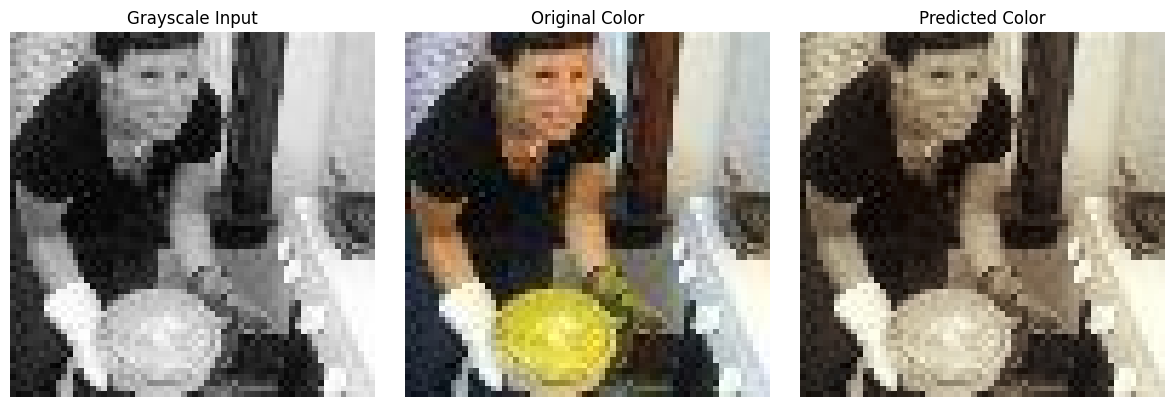

Test completed!


In [9]:
test_model('hyperunet_colorization.pth', '/kaggle/input/tiny-imagenet/tiny-imagenet-200/test/images/test_38.JPEG')

### This is new version of code for stl10

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import save_image
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

# STL-10 veri setini indir ve hazırla
def download_stl10(data_dir='./data'):
    """STL-10 veri setini indir"""
    print("Downloading STL-10 dataset...")
    
    # STL-10 train split (5000 labeled images)
    train_dataset = datasets.STL10(root=data_dir, split='train', download=True)
    
    # STL-10 unlabeled split (100000 unlabeled images) - daha fazla veri için
    unlabeled_dataset = datasets.STL10(root=data_dir, split='unlabeled', download=True)
    
    # STL-10 test split (8000 images)
    test_dataset = datasets.STL10(root=data_dir, split='test', download=True)
    
    print(f"Train samples: {len(train_dataset)}")
    print(f"Unlabeled samples: {len(unlabeled_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    
    return train_dataset, unlabeled_dataset, test_dataset

class HyperUNet(nn.Module):
    """
    Hyper-U-Net mimarisi - U-Net'e hypercolumn bağlantıları eklenir
    STL-10 için 96x96 input size'a uyarlandı
    """
    def __init__(self, input_channels=1, output_channels=2):
        super(HyperUNet, self).__init__()
        
        # Encoder (Downsampling) - 96x96 -> 6x6
        self.enc1 = self.conv_block(input_channels, 64)     # 96x96
        self.enc2 = self.conv_block(64, 128)                # 48x48
        self.enc3 = self.conv_block(128, 256)               # 24x24
        self.enc4 = self.conv_block(256, 512)               # 12x12
        self.enc5 = self.conv_block(512, 512)               # 6x6 (ek katman)
        
        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)        # 3x3
        
        # Decoder (Upsampling)
        self.up5 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec5 = self.conv_block(1024, 512)  # 512 + 512 from skip connection
        
        self.up4 = nn.ConvTranspose2d(512, 512, 2, stride=2)
        self.dec4 = self.conv_block(1024, 512)  # 512 + 512 from skip connection
        
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = self.conv_block(512, 256)   # 256 + 256 from skip connection
        
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = self.conv_block(256, 128)   # 128 + 128 from skip connection
        
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = self.conv_block(128, 64)    # 64 + 64 from skip connection
        
        # Hyper-column connections - 96x96 output size için
        self.hyper_conv1 = nn.Conv2d(64, 32, 1)
        self.hyper_conv2 = nn.Conv2d(128, 32, 1)
        self.hyper_conv3 = nn.Conv2d(256, 32, 1)
        self.hyper_conv4 = nn.Conv2d(512, 32, 1)
        self.hyper_conv5 = nn.Conv2d(512, 32, 1)
        
        # Final layer - hypercolumn features + final decoder features
        self.final_conv = nn.Conv2d(64 + 32*5, output_channels, 1)  # 64 + 160 = 224
        
        self.pool = nn.MaxPool2d(2, 2)
        
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)           # 96x96
        e1_pool = self.pool(e1)     # 48x48
        
        e2 = self.enc2(e1_pool)     # 48x48
        e2_pool = self.pool(e2)     # 24x24
        
        e3 = self.enc3(e2_pool)     # 24x24
        e3_pool = self.pool(e3)     # 12x12
        
        e4 = self.enc4(e3_pool)     # 12x12
        e4_pool = self.pool(e4)     # 6x6
        
        e5 = self.enc5(e4_pool)     # 6x6
        e5_pool = self.pool(e5)     # 3x3
        
        # Bottleneck
        bottleneck = self.bottleneck(e5_pool)  # 3x3
        
        # Decoder
        d5 = self.up5(bottleneck)   # 6x6
        d5 = torch.cat([d5, e5], dim=1)
        d5 = self.dec5(d5)
        
        d4 = self.up4(d5)           # 12x12
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)
        
        d3 = self.up3(d4)           # 24x24
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.up2(d3)           # 48x48
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        
        d1 = self.up1(d2)           # 96x96
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        
        # Hyper-column features - 96x96 boyutuna getir
        h1 = self.hyper_conv1(e1)  # 96x96
        h2 = F.interpolate(self.hyper_conv2(e2), size=(96, 96), mode='bilinear', align_corners=False)
        h3 = F.interpolate(self.hyper_conv3(e3), size=(96, 96), mode='bilinear', align_corners=False)
        h4 = F.interpolate(self.hyper_conv4(e4), size=(96, 96), mode='bilinear', align_corners=False)
        h5 = F.interpolate(self.hyper_conv5(e5), size=(96, 96), mode='bilinear', align_corners=False)
        
        # Tüm hyper-column features'ları birleştir
        hyper_features = torch.cat([h1, h2, h3, h4, h5], dim=1)
        
        # Final features: decoder output + hyper-column features
        final_features = torch.cat([d1, hyper_features], dim=1)
        
        # Final output
        output = self.final_conv(final_features)
        return torch.tanh(output)  # a,b channels için -1 ile 1 arası

class STL10ColorizationDataset(Dataset):
    """STL-10 için özelleştirilmiş colorization dataset"""
    def __init__(self, stl10_dataset, transform=None, use_unlabeled=True):
        self.stl10_dataset = stl10_dataset
        self.transform = transform
        self.use_unlabeled = use_unlabeled
    
    def __len__(self):
        return len(self.stl10_dataset)
    
    def __getitem__(self, idx):
        # STL-10 dataset'inden resmi al
        if self.use_unlabeled:
            rgb_image, _ = self.stl10_dataset[idx]  # unlabeled için label yok
        else:
            rgb_image, label = self.stl10_dataset[idx]
        
        # PIL Image'ı numpy array'e çevir
        if isinstance(rgb_image, Image.Image):
            rgb_np = np.array(rgb_image)
        else:
            rgb_np = rgb_image
        
        # Transform uygula
        if self.transform:
            rgb_image = self.transform(rgb_image)
            rgb_np = np.array(rgb_image)
        
        # LAB renk uzayına çevir
        lab_image = cv2.cvtColor(rgb_np, cv2.COLOR_RGB2LAB)
        lab_image = lab_image.astype(np.float32) / 255.0
        
        # L kanalını input olarak kullan (grayscale)
        L = lab_image[:, :, 0:1]  # Shape: (96, 96, 1)
        L = torch.from_numpy(L).permute(2, 0, 1)  # (1, 96, 96)
        
        # a,b kanallarını target olarak kullan
        ab = lab_image[:, :, 1:3]  # Shape: (96, 96, 2)
        ab = torch.from_numpy(ab).permute(2, 0, 1)  # (2, 96, 96)
        ab = ab * 2.0 - 1.0  # [-1, 1] aralığına normalize et
        
        return L, ab

def lab_to_rgb(L, ab, size=96):
    """LAB tensor'ları RGB'ye çevir - STL-10 için 96x96"""
    L = L.squeeze(0).cpu().numpy()  # (96, 96)
    ab = ab.cpu().numpy()  # (2, 96, 96)
    
    # [-1, 1]'den [0, 1]'e
    ab = (ab + 1.0) / 2.0
    
    # LAB formatına çevir
    lab = np.zeros((size, size, 3))
    lab[:, :, 0] = L
    lab[:, :, 1] = ab[0]
    lab[:, :, 2] = ab[1]
    
    # [0, 1]'den [0, 255]'e
    lab = (lab * 255).astype(np.uint8)
    
    # RGB'ye çevir
    rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    return rgb

def train_model():
    # Device seçimi
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # STL-10 veri setini indir ve hazırla
    train_dataset, unlabeled_dataset, test_dataset = download_stl10()
    
    # Transform tanımla - STL-10 için (96x96 native boyut)
    transform = transforms.Compose([
        transforms.Resize((96, 96)),  # STL-10 zaten 96x96 ama emin olmak için
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((96, 96)),
    ])
    
    # Dataset seçenekleri
    use_unlabeled_data = True  # Unlabeled veriyi de kullan (daha fazla veri)
    
    if use_unlabeled_data:
        # Hem labeled hem unlabeled veriyi kullan
        print("Using both labeled and unlabeled data for training")
        
        # Labeled veriyi train/val olarak böl
        train_labeled_dataset = STL10ColorizationDataset(train_dataset, transform=transform)
        
        # Unlabeled veriyi training'e ekle (daha büyük veri seti)
        train_unlabeled_dataset = STL10ColorizationDataset(unlabeled_dataset, transform=transform, use_unlabeled=True)
        
        # Test verisetini validation için kullan
        val_dataset = STL10ColorizationDataset(test_dataset, transform=val_transform)
        
        # Labeled ve unlabeled'ı birleştir
        from torch.utils.data import ConcatDataset
        combined_train_dataset = ConcatDataset([train_labeled_dataset, train_unlabeled_dataset])
        
        print(f"Total training samples: {len(combined_train_dataset)} (Labeled: {len(train_labeled_dataset)}, Unlabeled: {len(train_unlabeled_dataset)})")
        print(f"Validation samples: {len(val_dataset)}")
        
        train_loader = DataLoader(combined_train_dataset, batch_size=16, shuffle=True, num_workers=4)  # I've changed batch_size to 16 from 8
        val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)   #  I've changed batch_size to 16 from 8
        
    else:
        # Sadece labeled veriyi kullan
        print("Using only labeled data")
        train_dataset_color = STL10ColorizationDataset(train_dataset, transform=transform)
        val_dataset_color = STL10ColorizationDataset(test_dataset, transform=val_transform)
        
        print(f"Training samples: {len(train_dataset_color)}")
        print(f"Validation samples: {len(val_dataset_color)}")
        
        train_loader = DataLoader(train_dataset_color, batch_size=16, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_dataset_color, batch_size=16, shuffle=False, num_workers=4)
    
    # Model
    model = HyperUNet(input_channels=1, output_channels=2).to(device)
    
    # Model parametrelerini say
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Loss ve Optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)
    
    # Training loop
    
    # num_epochs = 50 if use_unlabeled_data else 30
    num_epochs = 30
    train_losses = []
    val_losses = []
    
    print(f"Starting training for {num_epochs} epochs...")
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        num_batches = len(train_loader)
        
        for i, (L, ab) in enumerate(train_loader):
            L, ab = L.to(device), ab.to(device)
            
            optimizer.zero_grad()
            outputs = model(L)
            loss = criterion(outputs, ab)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            # Her 100 batch'te bir progress göster
            if i % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{num_batches}], Loss: {loss.item():.4f}')
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for L, ab in val_loader:
                L, ab = L.to(device), ab.to(device)
                outputs = model(L)
                loss = criterion(outputs, ab)
                val_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        scheduler.step()
        
        # Her 5 epoch'ta bir örnek sonuçları kaydet
        if (epoch + 1) % 5 == 0:
            save_sample_results(model, val_loader, device, epoch+1)
    
    # Loss grafiği
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.grid(True)
    
    # Learning rate grafiği
    plt.subplot(1, 2, 2)
    lrs = [optimizer.param_groups[0]['lr'] * (0.5 ** (i // 15)) for i in range(num_epochs)]
    plt.plot(lrs, color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('stl10_training_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Modeli kaydet
    model_name = 'hyperunet_stl10_colorization.pth'
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'epoch': num_epochs
    }, model_name)
    print(f"Model saved as {model_name}")
    
    return model

def save_sample_results(model, val_loader, device, epoch):
    """Örnek sonuçları kaydet - STL-10 için 96x96"""
    model.eval()
    with torch.no_grad():
        for i, (L, ab_true) in enumerate(val_loader):
            if i > 0:  # Sadece ilk batch
                break
                
            L, ab_true = L.to(device), ab_true.to(device)
            ab_pred = model(L)
            
            # İlk 4 örneği kaydet
            for j in range(min(4, L.size(0))):
                # Grayscale input
                gray_img = L[j].cpu().numpy().squeeze()
                
                # Gerçek renkli resim
                true_rgb = lab_to_rgb(L[j], ab_true[j], size=96)
                
                # Tahmin edilen renkli resim
                pred_rgb = lab_to_rgb(L[j], ab_pred[j], size=96)
                
                # Yan yana göster
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                
                axes[0].imshow(gray_img, cmap='gray')
                axes[0].set_title('Grayscale Input')
                axes[0].axis('off')
                
                axes[1].imshow(true_rgb)
                axes[1].set_title('True Color')
                axes[1].axis('off')
                
                axes[2].imshow(pred_rgb)
                axes[2].set_title('Predicted Color')
                axes[2].axis('off')
                
                plt.tight_layout()
                plt.savefig(f'stl10_sample_epoch_{epoch}_img_{j}.png', dpi=150, bbox_inches='tight')
                plt.close()

def test_model(model_path, test_image_path=None):
    """Eğitilmiş modeli test et - STL-10 için"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Modeli yükle
    model = HyperUNet(input_channels=1, output_channels=2).to(device)
    
    # Checkpoint'i yükle
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    if test_image_path and os.path.exists(test_image_path):
        # Tek bir resmi test et
        rgb_image = Image.open(test_image_path).convert('RGB')
        rgb_image = rgb_image.resize((96, 96))  # STL-10 boyutuna getir
        
        # LAB'a çevir
        rgb_np = np.array(rgb_image)
        lab_image = cv2.cvtColor(rgb_np, cv2.COLOR_RGB2LAB)
        lab_image = lab_image.astype(np.float32) / 255.0
        
        L = lab_image[:, :, 0:1]
        L_tensor = torch.from_numpy(L).permute(2, 0, 1).unsqueeze(0).to(device)
        
        with torch.no_grad():
            ab_pred = model(L_tensor)
        
        # Sonucu görselleştir
        pred_rgb = lab_to_rgb(L_tensor.squeeze(0), ab_pred.squeeze(0), size=96)
        
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(L.squeeze(), cmap='gray')
        plt.title('Grayscale Input')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(rgb_np)
        plt.title('Original Color')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(pred_rgb)
        plt.title('Predicted Color')
        plt.axis('off')
        
        plt.tight_layout()
        plt.savefig('stl10_test_result.png', dpi=150, bbox_inches='tight')
        plt.show()
    else:
        # STL-10 test dataset'inden birkaç örnek test et
        _, _, test_dataset = download_stl10()
        test_transform = transforms.Compose([transforms.Resize((96, 96))])
        test_color_dataset = STL10ColorizationDataset(test_dataset, transform=test_transform)
        test_loader = DataLoader(test_color_dataset, batch_size=4, shuffle=True)
        
        model.eval()
        with torch.no_grad():
            L, ab_true = next(iter(test_loader))
            L, ab_true = L.to(device), ab_true.to(device)
            ab_pred = model(L)
            
            fig, axes = plt.subplots(3, 4, figsize=(16, 12))
            
            for i in range(4):
                # Grayscale
                axes[0, i].imshow(L[i].cpu().numpy().squeeze(), cmap='gray')
                axes[0, i].set_title(f'Grayscale {i+1}')
                axes[0, i].axis('off')
                
                # True color
                true_rgb = lab_to_rgb(L[i], ab_true[i], size=96)
                axes[1, i].imshow(true_rgb)
                axes[1, i].set_title(f'True Color {i+1}')
                axes[1, i].axis('off')
                
                # Predicted color
                pred_rgb = lab_to_rgb(L[i], ab_pred[i], size=96)
                axes[2, i].imshow(pred_rgb)
                axes[2, i].set_title(f'Predicted {i+1}')
                axes[2, i].axis('off')
            
            plt.tight_layout()
            plt.savefig('stl10_batch_test_results.png', dpi=150, bbox_inches='tight')
            plt.show()
    
    print("Test completed!")

Using device: cuda
Train samples: 5000
Unlabeled samples: 100000
Test samples: 8000
Using both labeled and unlabeled data for training
Total training samples: 105000 (Labeled: 5000, Unlabeled: 100000)
Validation samples: 8000
Total parameters: 43,941,730
Trainable parameters: 43,941,730
Starting training for 30 epochs...
Epoch [1/30], Step [1/6563], Loss: 0.0641
Epoch [1/30], Step [101/6563], Loss: 0.0057
Epoch [1/30], Step [201/6563], Loss: 0.0089
Epoch [1/30], Step [301/6563], Loss: 0.0117
Epoch [1/30], Step [401/6563], Loss: 0.0104
Epoch [1/30], Step [501/6563], Loss: 0.0077
Epoch [1/30], Step [601/6563], Loss: 0.0110
Epoch [1/30], Step [701/6563], Loss: 0.0080
Epoch [1/30], Step [801/6563], Loss: 0.0080
Epoch [1/30], Step [901/6563], Loss: 0.0099
Epoch [1/30], Step [1001/6563], Loss: 0.0090
Epoch [1/30], Step [1101/6563], Loss: 0.0075
Epoch [1/30], Step [1201/6563], Loss: 0.0089
Epoch [1/30], Step [1301/6563], Loss: 0.0065
Epoch [1/30], Step [1401/6563], Loss: 0.0093
Epoch [1/30], 

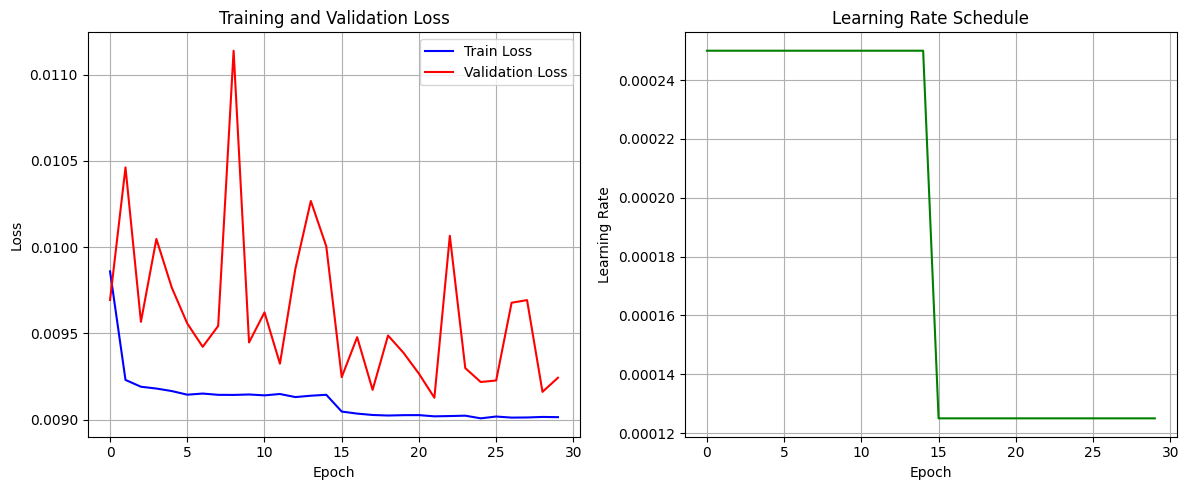

Model saved as hyperunet_stl10_colorization.pth


In [9]:
if __name__ == "__main__":
    # STL-10 ile modeli eğit
    model = train_model()
    
    # Test için örnek kullanım
    # test_model('hyperunet_stl10_colorization.pth')
    # test_model('hyperunet_stl10_colorization.pth', 'path_to_test_image.jpg')

Train samples: 5000
Unlabeled samples: 100000
Test samples: 8000


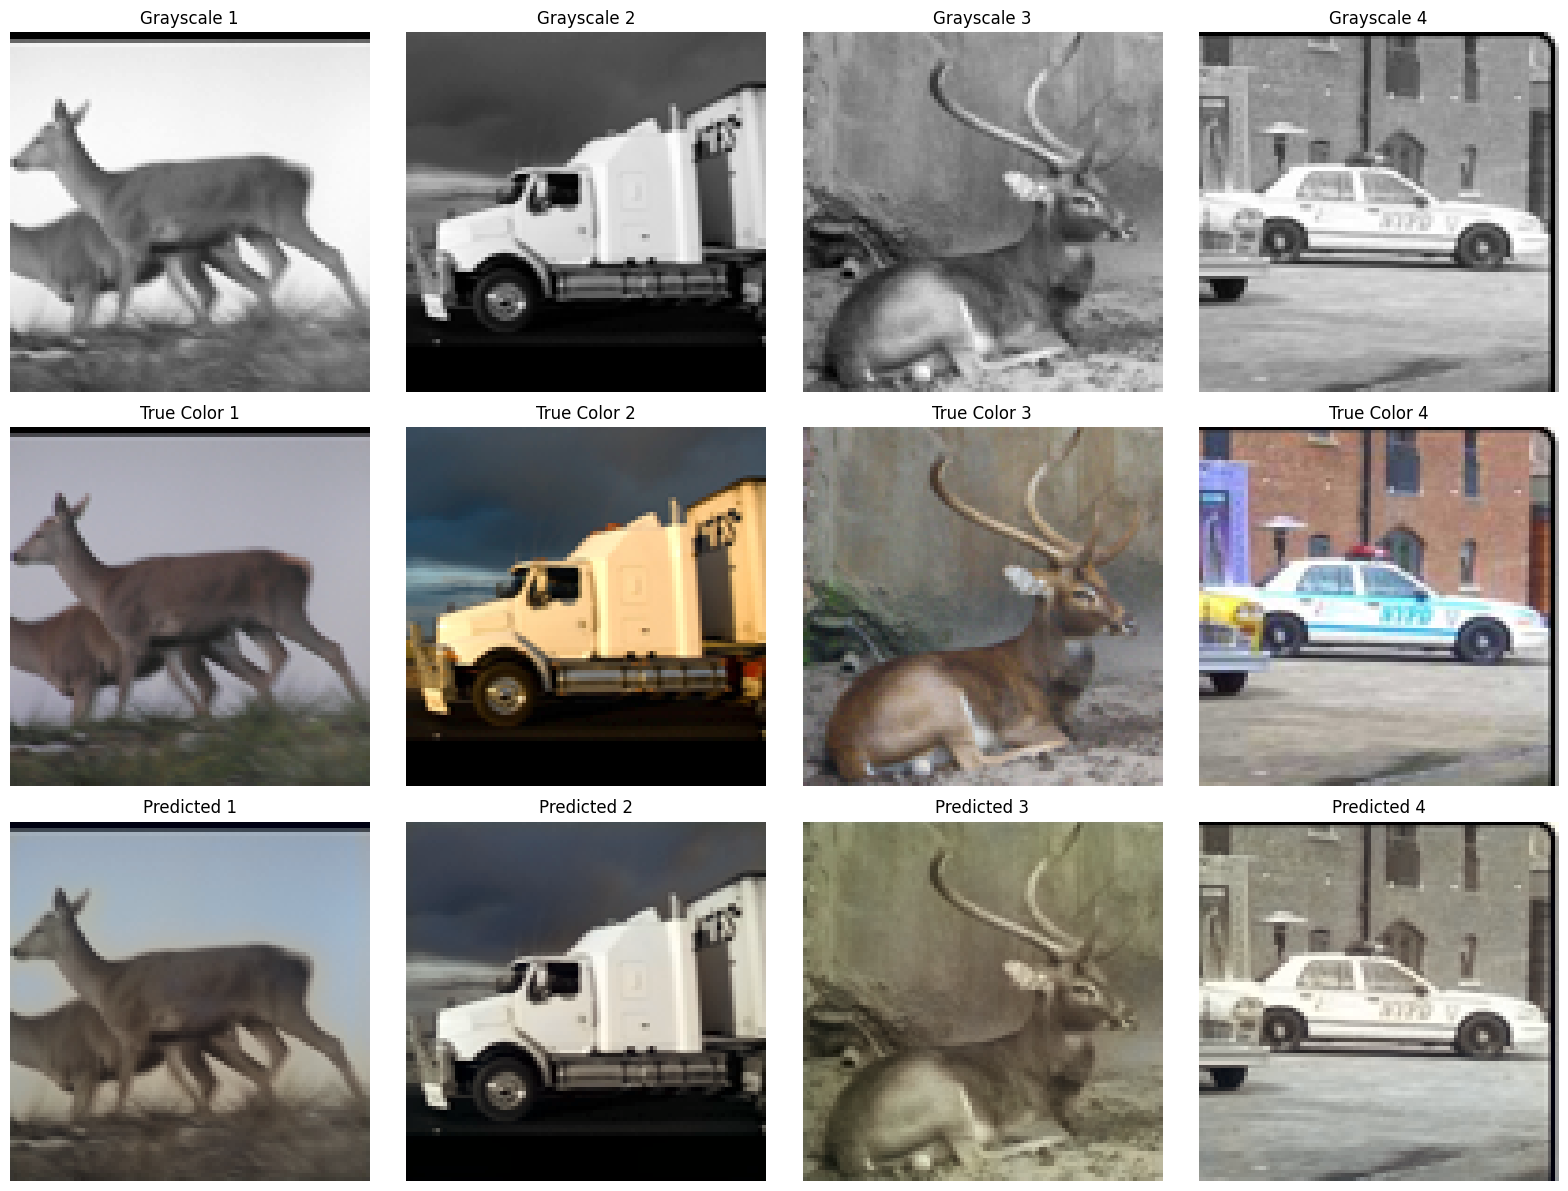

Test completed!


In [10]:
test_model('hyperunet_stl10_colorization.pth', 'path_to_test_image.jpg')